In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/Train.csv")
test = pd.read_csv('/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/Test.csv')
submission = pd.read_csv('/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/submission.csv')
##train = pd.read_csv("Train.csv")
##test = pd.read_csv('Test.csv')
#submission = pd.read_csv('SampleSubmission.csv')

In [4]:
#train.info()

In [5]:
train.describe()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field48,form_field49,form_field50
count,53471.000000,52156.000000,55645.000000,55645.000000,55645.000000,4.264000e+04,5.083700e+04,4.264000e+04,4.799200e+04,5.564500e+04,2.457900e+04,4.610500e+04,5.011100e+04,5.600000e+04,3.352500e+04,42964.000000,44849.000000,45598.000000,55996.000000,55645.000000,40146.000000,35600.000000,27877.000000,42703.000000,50550.000000,48562.000000,46701.000000,55645.000000,55645.000000,30491.000000,16592.000000,50550.000000,54744.000000,55645.000000,32852.000000,54005.000000,50550.000000,55645.000000,51789.000000,12271.000000,17771.000000,54677.000000,55432.000000,50617.000000,24683.000000,40096.000000,3.511100e+04,55645.000000,4.494400e+04
mean,3491.795665,0.550737,1.052225,0.851979,1.956317,6.244479e+05,6.865210e+06,2.626690e+06,1.316002e+07,1.185585e+07,2.054715e+06,2.771113e+06,6.009944e+06,6.914875e+07,1.145041e+08,0.230425,0.265692,0.271832,0.948800,1.031593,86.500380,6628.316381,6452.875072,104.558516,2624.555935,10106.554899,6190.516948,17274.315141,16518.540695,5213.246663,10857.565755,938.345321,13.926583,0.230245,0.199866,12.859069,8.480435,8.601420,0.090849,147.797977,108.117363,0.368215,6.634511,0.563377,0.072520,0.095371,3.052449e+05,1.049061,6.005862e+05
std,188.462426,0.820979,2.147768,3.157692,10.512396,1.433422e+06,1.912729e+07,3.927355e+06,1.977963e+07,2.669459e+07,4.912980e+06,4.544838e+06,2.335893e+07,2.713995e+09,1.153842e+08,0.621833,0.720198,0.725434,1.736454,1.785122,53.445528,5661.059297,5739.968774,436.670719,1964.226548,8796.472481,5390.915344,26930.742020,9666.183962,3124.491488,6049.678489,1044.597044,15.208396,0.683063,0.574002,10.621984,9.328810,7.969215,0.423802,45.085889,36.765769,0.412858,6.378946,0.196973,0.291146,0.335210,1.647757e+06,1.806160,5.842405e+06
min,2990.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.395430e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.255000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166600,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.021000,0.000000,0.000000,0.000000,0.048528,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,3358.000000,0.070788,0.000000,0.000000,0.000000,1.400400e+04,6.869740e+05,1.929440e+05,1.368502e+06,4.500730e+05,2.172565e+05,2.758010e+05,1.921660e+05,1.657646e+07,5.007636e+07,0.000000,0.000000,0.000000,0.000000,0.000000,40.305000,1068.667500,797.145000,14.865000,1231.500000,3375.000000,2068.000000,60.000000,9765.000000,2312.000000,6297.000000,194.000000,2.333400,0.000000,0.000000,6.000000,2.000000,4.000000,0.000000,136.191750,87.055500,0.000000,2.020000,0.411672,0.000000,0.000000,7.710079e+01,0.000000,4.560141e-02
50%,3484.000000,0.267575,0.062000,0.000000,0.000000,1.155330e+05,2.704328e+06,9.639420e+05,5.506295e+06,3.707559e+06,6.986440e+05,1.163110e+06,1.605792e+06,2.814143e+07,8.442428e+07,0.000000,0.000000,0.000000,0.000000,0.000000,89.167500,5976.225000,5548.935000,60.660000,2203.500000,8214.000000,5110.000000,486.000000,15057.000000,5658.000000,10584.000000,598.000000,7.833400,0.000000,0.000000,10.000000,6.000000,6.000000,0.000000,150.000000,118.441500,0.220000,5.050000,0.588648,0.000000,0.000000,3.181243e+02,0.000000,1.703996e-01
75%,3620.000000,0.719512,1.282000,0.000000,0.000000,5.259280e+05,6.993831e+06,3.751516e+06,1.694552

In [6]:
#train.isnull().sum()/len(train) * 100

In [7]:
new_train = train.drop(columns=['form_field31','form_field40','form_field41'])
#new_train = train
#print(new_train.head())

In [ ]:
#test.isnull().sum()/len(test) * 100

In [8]:
new_test = test.drop(columns=['form_field31','form_field40','form_field41'])
#new_test = test

# Training Catboost Algorithm with less preprocessing and feature engineering

## Feature Engineering

In [9]:
new_train.fillna(new_train.median(), inplace=True)

In [10]:
new_test.fillna(new_test.median(), inplace=True)

## Modelling

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder


In [12]:
pip install --quiet catboost

     |████████████████████████████████| 66.1MB 46kB/s 


In [13]:
X = new_train.drop(['default_status','Applicant_ID'], axis=1)
y =new_train.default_status

In [14]:
le = LabelEncoder()

In [15]:
X.form_field47.value_counts()

charge     36373
lending    19627
Name: form_field47, dtype: int64

In [16]:
X.form_field47 = le.fit_transform(X.form_field47)
new_test.form_field47 = le.fit_transform(new_test.form_field47)


In [17]:
#X_ = (X)
test_ = (new_test.drop('Applicant_ID', axis=1))

In [19]:
X.shape, y.shape, test_.shape

((56000, 47), (56000,), (24000, 47))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size= 0.2, random_state=42)

## Prediction

In [23]:
from catboost import CatBoostClassifier


In [24]:
cat = CatBoostClassifier(task_type='GPU')

In [26]:
cat.fit(X_train, y_train , verbose=1)

Learning rate set to 0.02735
0:	learn: 0.6759623	total: 58.7ms	remaining: 58.7s
1:	learn: 0.6591092	total: 115ms	remaining: 57.5s
2:	learn: 0.6444533	total: 154ms	remaining: 51.3s
3:	learn: 0.6300562	total: 211ms	remaining: 52.6s
4:	learn: 0.6172238	total: 277ms	remaining: 55s
5:	learn: 0.6046776	total: 330ms	remaining: 54.6s
6:	learn: 0.5926075	total: 383ms	remaining: 54.3s
7:	learn: 0.5821252	total: 445ms	remaining: 55.2s
8:	learn: 0.5719549	total: 499ms	remaining: 54.9s
9:	learn: 0.5628132	total: 551ms	remaining: 54.5s
10:	learn: 0.5547183	total: 604ms	remaining: 54.3s
11:	learn: 0.5470064	total: 656ms	remaining: 54s
12:	learn: 0.5398798	total: 710ms	remaining: 53.9s
13:	learn: 0.5330811	total: 766ms	remaining: 54s
14:	learn: 0.5263776	total: 822ms	remaining: 54s
15:	learn: 0.5204717	total: 883ms	remaining: 54.3s
16:	learn: 0.5154650	total: 939ms	remaining: 54.3s
17:	learn: 0.5105573	total: 991ms	remaining: 54.1s
18:	learn: 0.5056982	total: 1.04s	remaining: 53.9s
19:	learn: 0.501599

In [27]:
y_pred = cat.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.843241685296866

In [34]:
pred = cat.predict_proba(test_)
submission['default_status']= pred
submission.to_csv('sub12.csv', index=False)

## Kfold CV with 3 and 5 splits

3 splits showed improvement in roc score over 5 splits

In [28]:
from sklearn.model_selection import KFold

In [35]:
kf = KFold(n_splits=3)

In [36]:
#X_scaled1 = pd.DataFrame(X_)

roc_score = []
test_pred = []

for train_index, test_index in kf.split(X,y):
    x_train, x_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    
    model = cat.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test,y_pred)
    pred = model.predict_proba(test_)[:,1]
    roc_score.append(score)
    test_pred.append(pred)

Learning rate set to 0.027625
0:	learn: 0.6748390	total: 57.9ms	remaining: 57.8s
1:	learn: 0.6578815	total: 133ms	remaining: 1m 6s
2:	learn: 0.6425540	total: 186ms	remaining: 1m 1s
3:	learn: 0.6277413	total: 239ms	remaining: 59.5s
4:	learn: 0.6148772	total: 292ms	remaining: 58s
5:	learn: 0.6019959	total: 347ms	remaining: 57.4s
6:	learn: 0.5902737	total: 399ms	remaining: 56.7s
7:	learn: 0.5799853	total: 452ms	remaining: 56.1s
8:	learn: 0.5697172	total: 505ms	remaining: 55.6s
9:	learn: 0.5603119	total: 560ms	remaining: 55.5s
10:	learn: 0.5523708	total: 614ms	remaining: 55.2s
11:	learn: 0.5444501	total: 666ms	remaining: 54.8s
12:	learn: 0.5373391	total: 718ms	remaining: 54.5s
13:	learn: 0.5299561	total: 775ms	remaining: 54.6s
14:	learn: 0.5233827	total: 829ms	remaining: 54.5s
15:	learn: 0.5178342	total: 882ms	remaining: 54.2s
16:	learn: 0.5130295	total: 918ms	remaining: 53.1s
17:	learn: 0.5078172	total: 969ms	remaining: 52.9s
18:	learn: 0.5029690	total: 1.02s	remaining: 52.9s
19:	learn: 0

In [37]:
#prediction = gscv.predict_proba(test_sc)[:,1]
np.mean(roc_score)


0.8381411503911256

In [38]:
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('sub13.csv', index=False)

### Binning

In [ ]:
num_cols = new_train.select_dtypes(exclude='object').columns

In [ ]:
#for num in num_cols:
 # new_train[num + '_bin'] = pd.cut(new_train[num],bins=4)# duplicates='drop' 
 # new_test[num + '_bin'] = pd.cut(new_test[num],bins=4 )#duplicates='drop' 

#new_train['form_field1_bin'] = pd.cut(new_train.form_field1, bins=4)
#sns.countplot(s)

In [ ]:
#sns.countplot(new_train.form_field18_bin)

### Feature Interaction

In [ ]:
new_train['form_field1*formfield2'] = new_train['form_field1'] * new_train['form_field2']
new_train['form_field1/formfield2'] = new_train['form_field1'] / new_train['form_field2']

new_train['form_field1*formfield3'] = new_train['form_field1'] * new_train.form_field3
new_train['form_field1*formfield4'] = new_train.form_field1 * new_train.form_field4
new_train['form_field1*formfield5'] = new_train.form_field1 * new_train.form_field5

#new_train['form_field30*formfield41'] = new_train['form_field30'] * new_train['form_field41']
##new_train['form_field31*formfield40'] = new_train['form_field31'] * new_train['form_field40']

new_train['form_field6+field7'] =  (new_train.form_field6 + new_train.form_field8)/2
new_train['form_field13/field14'] = (new_train.form_field13 / new_train.form_field14)*100
new_train['form_field32/field33'] = (new_train['form_field32']+ new_train['form_field33'])/2
new_train['form_field36/field38'] = new_train['form_field36'] / new_train['form_field38']
new_train['form_field36/field39'] = new_train['form_field36'] / new_train['form_field39']
new_train['form_field36/field18'] = new_train['form_field36'] / new_train['form_field18']
new_train['form_field36/field20'] = new_train['form_field36'] / new_train['form_field20']
new_train['form_field44*field50'] = new_train['form_field44'] * new_train['form_field50']




In [ ]:
new_test['form_field1*formfield2'] = new_test['form_field1'] * new_test['form_field2']
new_test['form_field1/formfield2'] = new_test['form_field1'] / new_test['form_field2']

new_test['form_field1*formfield3'] = new_test['form_field1'] * new_test.form_field3
new_test['form_field1*formfield4'] = new_test.form_field1 * new_test.form_field4
new_test['form_field1*formfield5'] = new_test.form_field1 * new_test.form_field5

#new_train['form_field30*formfield41'] = new_train['form_field30'] * new_train['form_field41']
##new_train['form_field31*formfield40'] = new_train['form_field31'] * new_train['form_field40']

new_test['form_field6+field7'] =  (new_test.form_field6 + new_test.form_field8)/2
new_test['form_field13/field14'] = (new_test.form_field13 / new_test.form_field14)*100
new_test['form_field32/field33'] = (new_test['form_field32']+ new_test['form_field33'])/2
new_test['form_field36/field38'] = new_test['form_field36'] / new_test['form_field38']
new_test['form_field36/field39'] = new_test['form_field36'] / new_test['form_field39']
new_test['form_field36/field18'] = new_test['form_field36'] / new_test['form_field18']
new_test['form_field36/field20'] = new_test['form_field36'] / new_test['form_field20']
new_test['form_field44*field50'] = new_test['form_field44'] * new_test['form_field50']




### Data Aggregation

In [ ]:
for col in num_cols:
    new_train[col + '_mean_on_field1'] = new_train[col].groupby(new_train['form_field1']).transform('mean')
    new_train[col + '_mean_on_field2'] = new_train[col].groupby(new_train['form_field2']).transform('mean')

    new_train[col + '_sum_on_field1'] = new_train[col].groupby(new_train['form_field1']).transform('sum')
    new_train[col + '_sum_on_field2'] = new_train[col].groupby(new_train['form_field2']).transform('sum')

    new_train[col + '_mean_on_field1'] = new_train[col].groupby(new_train['form_field1']).transform('max')
    new_train[col + '_mean_on_field2'] = new_train[col].groupby(new_train['form_field2']).transform('max')

    new_train[col + '_sum_on_field1'] = new_train[col].groupby(new_train['form_field1']).transform('min')
    new_train[col + '_sum_on_field2'] = new_train[col].groupby(new_train['form_field2']).transform('min')


    new_test[col + '_mean_on_field1'] = new_test[col].groupby(new_test['form_field1']).transform('mean')
    new_test[col + '_mean_on_field2'] = new_test[col].groupby(new_test['form_field2']).transform('mean')

    new_test[col + '_sum_on_field1'] = new_test[col].groupby(new_test['form_field1']).transform('sum')
    new_test[col + '_sum_on_field2'] = new_test[col].groupby(new_test['form_field2']).transform('sum')

    new_test[col + '_mean_on_field1'] = new_test[col].groupby(new_test['form_field1']).transform('max')
    new_test[col + '_mean_on_field2'] = new_test[col].groupby(new_test['form_field2']).transform('max')

    new_test[col + '_sum_on_field1'] = new_test[col].groupby(new_test['form_field1']).transform('min')
    new_test[col + '_sum_on_field2'] = new_test[col].groupby(new_test['form_field2']).transform('min')




    new_train[col + '_mean_on_field1_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field1']]).transform('mean')
    new_train[col + '_mean_on_field2_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field2']]).transform('mean')

    new_train[col + '_sum_on_field1_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field1']]).transform('sum')
    new_train[col + '_sum_on_field2_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field2']]).transform('sum')

    new_train[col + '_mean_on_field1_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field1']]).transform('max')
    new_train[col + '_mean_on_field2_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field2']]).transform('max')

    new_train[col + '_sum_on_field1_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field1']]).transform('min')
    new_train[col + '_sum_on_field2_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field2']]).transform('min')


    new_test[col + '_mean_on_field1_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field1']]).transform('mean')
    new_test[col + '_mean_on_field2_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field2']]).transform('mean')

    new_test[col + '_sum_on_field1_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field1']]).transform('sum')
    new_test[col + '_sum_on_field2_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field2']]).transform('sum')

    new_test[col + '_mean_on_field1_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field1']]).transform('max')
    new_test[col + '_mean_on_field2_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field2']]).transform('max')

    new_test[col + '_sum_on_field1_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field1']]).transform('min')
    new_test[col + '_sum_on_field2_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field2']]).transform('min')
    
    
    

In [ ]:
#new_train[col].groupby([new_train['form_field1'],new_train['form_field47']]).transform('mean')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
X = new_train.drop(['default_status','Applicant_ID'], axis=1)
y =new_train.default_status

In [ ]:
#y_ = pd.get_dummies(y)

In [ ]:
X.form_field47 = le.fit_transform(X.form_field47)
new_test.form_field47 = le.fit_transform(new_test.form_field47)


In [ ]:
X_ = (X)
test_ = (new_test.drop('Applicant_ID', axis=1))

In [ ]:
#cat_cols = X_.select_dtypes(include='category').columns
#cat_cols

In [ ]:
test_.shape

(24000, 427)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
minmax = MinMaxScaler()

In [ ]:
#X_scaled = minmax.fit_transform(X_)
#test_sc = minmax.fit_transform(test_)

In [ ]:
pip install --quiet catboost

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier



In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
cat = CatBoostClassifier()
xgb = XGBClassifier()
lgb = LGBMClassifier()
ada = AdaBoostClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV, cross_val_score

In [ ]:
from sklearn.metrics import roc_auc_score

## Applied Kfold CV

In [ ]:
kf = KFold(n_splits=5)
cat = CatBoostClassifier(task_type='GPU')#, cat_features=cat_cols)#, learning_rate=0.02, n_estimators=2000, depth=7, early_stopping_rounds=50)


In [ ]:
X_scaled1 = pd.DataFrame(X_)

roc_score = []
test_pred = []

for train_index, test_index in kf.split(X_scaled1,y):
    x_train, x_test = X_scaled1.iloc[train_index],X_scaled1.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    
    model = cat.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test,y_pred)
    pred = model.predict_proba(test_)[:,1]
    roc_score.append(score)
    test_pred.append(pred)
  #save result to list

Streaming output truncated to the last 5000 lines.
5:	learn: 0.6043388	total: 544ms	remaining: 1m 30s
6:	learn: 0.5925768	total: 618ms	remaining: 1m 27s
7:	learn: 0.5816823	total: 688ms	remaining: 1m 25s
8:	learn: 0.5719720	total: 765ms	remaining: 1m 24s
9:	learn: 0.5631376	total: 839ms	remaining: 1m 23s
10:	learn: 0.5549871	total: 904ms	remaining: 1m 21s
11:	learn: 0.5474445	total: 979ms	remaining: 1m 20s
12:	learn: 0.5401917	total: 1.05s	remaining: 1m 19s
13:	learn: 0.5330203	total: 1.12s	remaining: 1m 18s
14:	learn: 0.5268883	total: 1.18s	remaining: 1m 17s
15:	learn: 0.5214726	total: 1.25s	remaining: 1m 16s
16:	learn: 0.5157886	total: 1.31s	remaining: 1m 16s
17:	learn: 0.5115082	total: 1.38s	remaining: 1m 15s
18:	learn: 0.5062677	total: 1.44s	remaining: 1m 14s
19:	learn: 0.5017765	total: 1.51s	remaining: 1m 14s
20:	learn: 0.4975121	total: 1.58s	remaining: 1m 13s
21:	learn: 0.4939940	total: 1.64s	remaining: 1m 12s
22:	learn: 0.4900412	total: 1.71s	remaining: 1m 12s
23:	learn: 0.48654

In [ ]:
np.mean(roc_score)

0.8359028548944547

In [ ]:
test

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50
0,Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0000,418564.0,418564.0,418564.0,540710.0,0.0,1649749.0,5446.0,0.0,48187375,114686147.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1086.0,6204.0,2676.0,60.0,14691.0,9794.0,NaN,238.0,1.8334,0.0,NaN,22.0,2.0,14.0,0.0,NaN,NaN,0.825000,1.01,0.800000,NaN,0.0,charge,NaN,0.000000,0.011221
1,Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0000,0.0,9858816.0,49014.0,1510098.0,18308285.0,622789.0,1025793.0,1396510.0,34694910,87479487.0,1.0,1.0,1.0,2.0,2.0,142.560,NaN,NaN,570.585,3082.5,10221.0,6814.0,60.0,11955.0,3528.0,NaN,1216.0,19.5000,3.0,NaN,30.0,18.0,14.0,2.0,NaN,18.8415,0.507694,4.04,0.623248,1.0,0.0,lending,NaN,0.504974,0.043525
2,Apcnt_1000052,NaN,0.27505,0.0600,0.0000,0.0000,NaN,NaN,NaN,NaN,0.0,118256.0,NaN,NaN,21973443,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,852.0,4836.0,NaN,NaN,NaN,7.8334,0.0,NaN,2.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,charge,NaN,0.000000,NaN
3,Apcnt_1000076,3232.0,0.28505,2.8032,0.0000,0.0000,0.0,473802.0,473802.0,1724437.0,493641.0,1391064.0,1176725.0,1220293.0,16576457,NaN,2.0,2.0,2.0,3.0,3.0,109.005,13050.000,NaN,109.005,1414.5,4197.0,2798.0,60.0,14964.0,NaN,NaN,248.0,9.0000,1.0,1.0,36.0,0.0,26.0,0.0,NaN,NaN,0.916663,2.02,0.464224,NaN,NaN,charge,90.163742,0.788809,0.104029
4,Apcnt_1000080,3466.0,2.09545,0.8318,2.5182,0.0000,19839.0,1150662.0,1150662.0,7860523.0,5752921.0,271133.0,613064.0,4779643.0,48187375,72049802.0,0.0,0.0,0.0,3.0,3.0,139.065,469.290,469.290,15.180,2724.0,9855.0,6570.0,182.0,11679.0,5900.0,NaN,2388.0,16.6666,1.0,0.0,24.0,28.0,20.0,0.0,NaN,NaN,0.234047,23.23,0.726688,0.0,0.0,lending,1303.587148,1.637733,0.163124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,Apcnt_999940,3258.0,0.37925,0.5698,5.1282,0.0000,NaN,2280318.0,NaN,NaN,2280318.0,1743887.0,NaN,0.0,21973443,126128971.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,547.5,NaN,NaN,304.0,3741.0,2068.0,NaN,24.0,0.3334,0.0,0.0,6.0,0.0,6.0,0.0,NaN,92.6910,1.100000,0.00,0.800000,NaN,1.0,charge,NaN,0.000000,NaN
23996,Apcnt_999956,3514.0,0.95260,0.0000,0.0000,0.0000,1494538.0,4773419.0,4773419.0,89718571.0,12999991.0,NaN,48989882.0,97696961.0,96375139,NaN,0.0,0.0,0.0,3.0,3.0,123.195,11663.055,NaN,123.195,1485.0,6387.0,4258.0,60772.0,14691.0,3286.0,NaN,586.0,14.1666,0.0,0.0,10.0,2.0,8.0,0.0,NaN,125.0220,0.000000,12.12,0.196400,0.0,0.0,charge,4200.072959,3.000000,0.930931
23997,Apcnt_999976,3302.0,0.05755,4.2394,0.0000,25.4376,NaN,49403.0,NaN,NaN,49403.0,215895.0,NaN,0.0,21973443,NaN,NaN,NaN,0.0,0.0,1.0,NaN,13080.000,NaN,NaN,2304.0,NaN,NaN,60.0,10038.0,NaN,5109.0,202.0,5.3334,0.0,NaN,8.0,4.0,2.0,0.0,NaN,NaN,1.100000,1.01,0.800000,NaN,0.0,charge,NaN,4.855060,NaN
23998,Apcnt_999984,3334.0,0.75670,1.4428,0.0000,0.0000,0.0,2513329.0,37733.0,393668.0,2551062.0,121757.0,355935.0,673748.0,16576457,NaN,1.0,2.0,2.0,2.0,2.0,129.435,13024.995,13024.995,138.450,706.5,2463.0,1642.0,0.0,6297.0,2312.0,NaN,62.0,2.6666,0.0,0.0,12.0,0.0,4.0,0.0,NaN,31.1955,0.440000,2.02,0.519776,NaN,0.0,charge,27.325129,0.818733,0.023749


In [ ]:
submission['Applicant_ID'] = test['Applicant_ID']

In [ ]:
#prediction = gscv.predict_proba(test_sc)[:,1]
np.mean(roc_score)
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('sub10.csv', index=False)

In [ ]:
cat.feature_importances_

array(None, dtype=object)

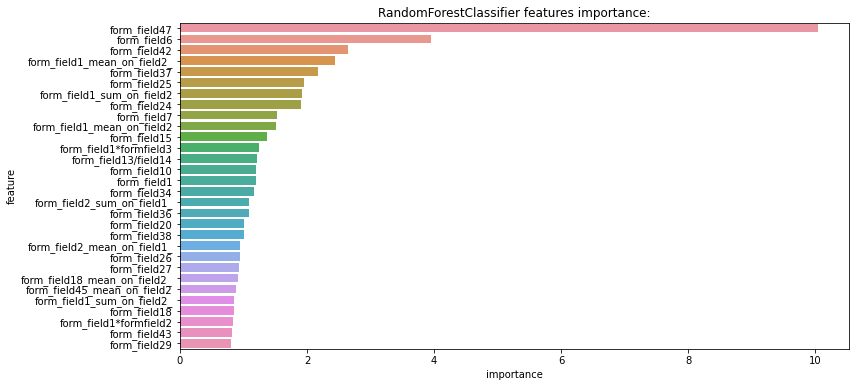

In [ ]:
feature_importance_df = pd.DataFrame(cat.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = test_.columns

plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(30))
plt.title('RandomForestClassifier features importance:');

In [ ]:
grid = {'learning_rate': [ 0.05],}
        #'n_estimators': [300, 500] }
       # 'depth': [4,6],}
        #'l2_leaf_reg': [3, 5]}

"""grid_search_result = cat.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)"""

In [ ]:
cat = CatBoostClassifier(task_type='GPU', depth=7, n_estimators=1500, early_stopping_rounds=50)


gscv = GridSearchCV(cat, param_grid=grid)

Tried GridSearch CV

In [ ]:
gscv.fit(X_train, y_train)

In [ ]:
gscv_pred = gscv.predict_proba(X_test)[:,1]
roc_auc_score(y_test, gscv_pred)


In [ ]:
\\prediction = gscv.predict_proba(test_sc)[:,1]

submission['default_status']=prediction
submission.to_csv('submission4.csv', index=False)


In [ ]:
cat = CatBoostClassifier(task_type='GPU', learning_rate=0.03, depth=4, n_estimators=3000, early_stopping_rounds=50)

cat.fit(X_train, y_train, eval_set=(X_test, y_test))

In [ ]:
from sklearn.metrics import roc_auc_score, log_loss

In [ ]:
pred = cat.predict_proba(X_test)[:,1]

In [ ]:
roc_auc_score(y_test, pred)


In [ ]:
roc_auc_score(y_test, pred)


In [ ]:
roc_auc_score(y_test, pred)

In [ ]:
models = [cat, xgb, lgb, ada, rf, lr]

for model in models:
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test,pred)
    print(f'the auc score for {model} is {score}')

In [ ]:
prediction = cat.predict_proba(test_sc)[:,1]

In [ ]:
submission.head()

In [ ]:
prediction = cat.predict_proba(test_sc)[:,1]

submission['default_status']=prediction
submission.to_csv('submission3.csv', index=False)


In [ ]:
submission.to_csv('submission3.csv', index=False)

In [ ]:
len(cat.feature_importances_)
len(test_.columns)

In [ ]:
pip install seaborn

In [ ]:
import seaborn as sns

In [ ]:
feature_importance_df = pd.DataFrame(cat.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = test_.columns

plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(30))
plt.title('RandomForestClassifier features importance:');

## Feature Engineering

In [ ]:
new_train.loc[new_train.form_field1>=3500,'form_field1']=1